Authors:

Daniel Gorsia 206091407

Omer Nagar 307937714

Shachar Meretz 208240275

Peleg Biton 203842703

Asaf Zaks 302329693

# Install & Imports

In [ ]:
!pip3 install shap
!pip3 install mlxtend

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error ,r2_score
from sklearn.svm import SVR
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')
print(df.shape)
df.head()

(3648, 73)


,Retlplts Retail sell Date,Retlplts Retail sell Mid-Price,Core Cpi Date,Core Cpi Latest,Core Cpi Survey,Core pce Date,Core pce Latest,Core pce Survey,NY New Jobs 2 Date,NY New Jobs 2 Latest,NY New Jobs 1 Date,NY New Jobs 1 Latest,NY New Jobs 1 Survey,Real GBP Date,Real GBP Latest,Real GBP Survey,Nominal GDP Date,Nominal GDP Latest,Nominal GDP Survey,Personal Consumption Date,Personal Consumption Latest,Personal Consumption Survey,Private Investment Date,Private Investment Latest,Private Investment Survey,Government Spending Date,Government Spending Latest,Government Spending Survey,Retail & Food Sales Date,Retail & Food Sales Latest,Retail & Food Sales Survey,Industrial Production Date,Industrial Production Latest,Industrial Production Survey,Conf. Board Consumer Confidence Date,Conf. Board Consumer Confidence Latest,Conf. Board Consumer Confidence Survey,U. Mich. Consumer Sentiment Date,U. Mich. Consumer Sentiment Latest,U. Mich. Consumer Sentiment Survey,ISM Manufacturing PMI Date,ISM Manufacturing PMI Latest,ISM Manufacturing PMI Survey,Unemployment Rate Date,Unemployment Rate Latest,Unemployment Rate Survey,Long-Term Unemployment Rate Date,Long-Term Unemployment Rate Latest,Long-Term Unemployment Rate Survey,Underemployment Rate Date,Underemployment Rate Latest,Underemployment Rate Survey,Labor Force Participation Rate Date,Labor Force Participation Rate Latest,Labor Force Participation Rate Survey,US Employees on Non Farm Payrolls Date,US Employees on Non Farm Payrolls Latest,US Employees on Non Farm Payrolls Survey,US Job Openings Rates Date,US Job Openings Rates Latest,US Job Openings Rates Survey,US Hires Rates Date,US Hires Rates Latest,US Hires Rates Survey,Gold Date,Gold Adj-Close,SPY Date,SPY Adj-Close,Interest on Excess Reserves Date,Interest on Excess Reserves Latest,Interest on Excess Reserves Survey,Commodity Date,Commodity Adj-Close
0,25/12/2020,3834.0,31/12/2020,NaN,1.6,30/11/2020,1.37866,1.400,30/09/2020,377.0,31/12/2020,NaN,6.8,30/09/2020,-2.8,NaN,30/09/2020,-1.7,NaN,30/09/2020,-2.8,NaN,30/09/2020,86.3,NaN,30/09/2020,-4.8,NaN,30/11/2020,4.1,NaN,30/11/2020,-5.50,NaN,31/12/2020,88.6,97.0,31/12/2020,80.7,81.1,31/12/2020,NaN,56.5,31/12/2020,NaN,6.8,30/11/2020,36.9,NaN,30/11/2020,12.0,NaN,30/11/2020,61.5,61.7,30/11/2020,-6.05,NaN,31/10/2020,4.5,NaN,31/10/2020,4.1,NaN,01/12/2020,1893.099976,01/12/2020,28.830000,04/01/2021,0.1,NaN,21/07/2006,49.250000
1,30/11/2020,3605.0,30/11/2020,1.6,1.5,31/10/2020,1.41399,1.400,31/08/2020,374.0,30/11/2020,6.7,6.7,30/06/2020,-9.0,NaN,30/06/2020,-8.5,NaN,30/06/2020,-10.2,NaN,30/06/2020,-46.6,NaN,30/06/2020,2.5,NaN,31/10/2020,5.5,NaN,31/10/2020,-5.00,NaN,30/11/2020,92.9,98.0,30/11/2020,76.9,77.0,30/11/2020,57.5,58.0,30/11/2020,6.7,6.7,31/10/2020,32.5,NaN,31/10/2020,12.1,NaN,31/10/2020,61.7,61.5,31/10/2020,-6.05,NaN,30/09/2020,4.4,NaN,30/09/2020,4.2,NaN,01/11/2020,1775.699951,01/11/2020,28.440001,31/12/2020,0.1,NaN,24/07/2006,49.700001
2,30/10/2020,3280.0,31/10/2020,1.6,1.7,30/09/2020,1.52891,1.700,31/07/2020,356.0,31/10/2020,6.9,7.6,31/03/2020,0.3,NaN,31/03/2020,2.1,NaN,31/03/2020,0.2,NaN,31/03/2020,-9.0,NaN,31/03/2020,1.3,NaN,30/09/2020,6.1,NaN,30/09/2020,-6.28,NaN,31/10/2020,101.4,102.0,31/10/2020,81.8,81.2,31/10/2020,59.3,56.0,31/10/2020,6.9,7.6,30/09/2020,19.1,NaN,30/09/2020,12.8,NaN,30/09/2020,61.4,61.9,30/09/2020,-6.34,NaN,31/08/2020,4.3,NaN,31/08/2020,4.2,NaN,01/10/2020,1877.400024,01/10/2020,18.430000,30/12/2020,0.1,NaN,25/07/2006,49.250000
3,30/09/2020,3394.0,30/09/2020,1.7,1.7,31/08/2020,1.42760,1.400,30/06/2020,317.0,30/09/2020,7.9,8.2,31/12/2019,2.3,NaN,31/12/2019,4.0,NaN,31/12/2019,2.5,NaN,31/12/2019,-3.7,NaN,31/12/2019,2.4,NaN,31/08/2020,3.6,NaN,31/08/2020,-6.55,NaN,30/09/2020,101.3,90.0,30/09/2020,80.4,79.0,30/09/2020,55.4,56.5,30/09/2020,7.9,8.2,31/08/2020,12.0,NaN,31/08/2020,14.2,NaN,31/08/2020,61.7,61.8,31/08/2020,-6.68,NaN,31/07/2020,4.6,NaN,31/07/2020,4.2,NaN,01/09/2020,1887.500000,01/09/2020,17.950001,29/12/2020,0.1,NaN,26/07/2006,49.619999
4,31/08/2020,3555.0

In [ ]:
# drop columns that are all nan's
df = df.dropna(axis=1, how='all')
print(df.shape)
df.head()

(3648, 62)


,Retlplts Retail sell Date,Retlplts Retail sell Mid-Price,Core Cpi Date,Core Cpi Latest,Core Cpi Survey,Core pce Date,Core pce Latest,Core pce Survey,NY New Jobs 2 Date,NY New Jobs 2 Latest,NY New Jobs 1 Date,NY New Jobs 1 Latest,NY New Jobs 1 Survey,Real GBP Date,Real GBP Latest,Nominal GDP Date,Nominal GDP Latest,Personal Consumption Date,Personal Consumption Latest,Private Investment Date,Private Investment Latest,Government Spending Date,Government Spending Latest,Retail & Food Sales Date,Retail & Food Sales Latest,Industrial Production Date,Industrial Production Latest,Conf. Board Consumer Confidence Date,Conf. Board Consumer Confidence Latest,Conf. Board Consumer Confidence Survey,U. Mich. Consumer Sentiment Date,U. Mich. Consumer Sentiment Latest,U. Mich. Consumer Sentiment Survey,ISM Manufacturing PMI Date,ISM Manufacturing PMI Latest,ISM Manufacturing PMI Survey,Unemployment Rate Date,Unemployment Rate Latest,Unemployment Rate Survey,Long-Term Unemployment Rate Date,Long-Term Unemployment Rate Latest,Underemployment Rate Date,Underemployment Rate Latest,Underemployment Rate Survey,Labor Force Participation Rate Date,Labor Force Participation Rate Latest,Labor Force Participation Rate Survey,US Employees on Non Farm Payrolls Date,US Employees on Non Farm Payrolls Latest,US Job Openings Rates Date,US Job Openings Rates Latest,US Hires Rates Date,US Hires Rates Latest,Gold Date,Gold Adj-Close,SPY Date,SPY Adj-Close,Interest on Excess Reserves Date,Interest on Excess Reserves Latest,Interest on Excess Reserves Survey,Commodity Date,Commodity Adj-Close
0,25/12/2020,3834.0,31/12/2020,NaN,1.6,30/11/2020,1.37866,1.400,30/09/2020,377.0,31/12/2020,NaN,6.8,30/09/2020,-2.8,30/09/2020,-1.7,30/09/2020,-2.8,30/09/2020,86.3,30/09/2020,-4.8,30/11/2020,4.1,30/11/2020,-5.50,31/12/2020,88.6,97.0,31/12/2020,80.7,81.1,31/12/2020,NaN,56.5,31/12/2020,NaN,6.8,30/11/2020,36.9,30/11/2020,12.0,NaN,30/11/2020,61.5,61.7,30/11/2020,-6.05,31/10/2020,4.5,31/10/2020,4.1,01/12/2020,1893.099976,01/12/2020,28.830000,04/01/2021,0.1,NaN,21/07/2006,49.250000
1,30/11/2020,3605.0,30/11/2020,1.6,1.5,31/10/2020,1.41399,1.400,31/08/2020,374.0,30/11/2020,6.7,6.7,30/06/2020,-9.0,30/06/2020,-8.5,30/06/2020,-10.2,30/06/2020,-46.6,30/06/2020,2.5,31/10/2020,5.5,31/10/2020,-5.00,30/11/2020,92.9,98.0,30/11/2020,76.9,77.0,30/11/2020,57.5,58.0,30/11/2020,6.7,6.7,31/10/2020,32.5,31/10/2020,12.1,NaN,31/10/2020,61.7,61.5,31/10/2020,-6.05,30/09/2020,4.4,30/09/2020,4.2,01/11/2020,1775.699951,01/11/2020,28.440001,31/12/2020,0.1,NaN,24/07/2006,49.700001
2,30/10/2020,3280.0,31/10/2020,1.6,1.7,30/09/2020,1.52891,1.700,31/07/2020,356.0,31/10/2020,6.9,7.6,31/03/2020,0.3,31/03/2020,2.1,31/03/2020,0.2,31/03/2020,-9.0,31/03/2020,1.3,30/09/2020,6.1,30/09/2020,-6.28,31/10/2020,101.4,102.0,31/10/2020,81.8,81.2,31/10/2020,59.3,56.0,31/10/2020,6.9,7.6,30/09/2020,19.1,30/09/2020,12.8,NaN,30/09/2020,61.4,61.9,30/09/2020,-6.34,31/08/2020,4.3,31/08/2020,4.2,01/10/2020,1877.400024,01/10/2020,18.430000,30/12/2020,0.1,NaN,25/07/2006,49.250000
3,30/09/2020,3394.0,30/09/2020,1.7,1.7,31/08/2020,1.42760,1.400,30/06/2020,317.0,30/09/2020,7.9,8.2,31/12/2019,2.3,31/12/2019,4.0,31/12/2019,2.5,31/12/2019,-3.7,31/12/2019,2.4,31/08/2020,3.6,31/08/2020,-6.55,30/09/2020,101.3,90.0,30/09/2020,80.4,79.0,30/09/2020,55.4,56.5,30/09/2020,7.9,8.2,31/08/2020,12.0,31/08/2020,14.2,NaN,31/08/2020,61.7,61.8,31/08/2020,-6.68,31/07/2020,4.6,31/07/2020,4.2,01/09/2020,1887.500000,01/09/2020,17.950001,29/12/2020,0.1,NaN,26/07/2006,49.619999
4,31/08/2020,3555.0,31/08/2020,1.7,1.6,31/07/2020,1.25740,1.225,31/05/2020,329.0,31/08/2020,8.4,9.8,30/09/2019,2.1,30/09/2019,3.8,30/09/2019,2.5,30/09/2019,1.8,30/09/2019,2.1,31/07/2020,2.7,31/07/2020,-6.59,31/08/2020,86.3,93.0,31/08/2020,74.1,72.8,31/08/2020,56.0,54.8,31/08/2020,8.4,9.8,31/07/2020,9.2,31/07/2020,16.5,NaN,31/07/2020,61.4,61.8,31/07/2020,-7.54,30/06/2020,4.2,30/06/2020,5.1,01/08/2020,1967.599976,01/08/2020,20.510000,28/12/2020,0.1,NaN,27/07/2006,50.150002


In [ ]:
column_ext = set()
for col in df.columns:
  ext = col.split(' ')[-1]
  column_ext.add(ext)
column_ext

{'Adj-Close', 'Date', 'Latest', 'Mid-Price', 'Survey'}

In [ ]:
# get unique columnns
# column_ext = ['Date', 'Mid Price', 'Latest', 'Survey', 'Adj Close']
unique_cols = set()
for col in df.columns:
    c = col
    for ext in column_ext:
        c = c.replace(ext, '')
    c = c.strip()
    unique_cols.add(c)
unique_cols

{'Commodity',
 'Conf. Board Consumer Confidence',
 'Core Cpi',
 'Core pce',
 'Gold',
 'Government Spending',
 'ISM Manufacturing PMI',
 'Industrial Production',
 'Interest on Excess Reserves',
 'Labor Force Participation Rate',
 'Long-Term Unemployment Rate',
 'NY New Jobs 1',
 'NY New Jobs 2',
 'Nominal GDP',
 'Personal Consumption',
 'Private Investment',
 'Real GBP',
 'Retail & Food Sales',
 'Retlplts Retail sell',
 'SPY',
 'U. Mich. Consumer Sentiment',
 'US Employees on Non Farm Payrolls',
 'US Hires Rates',
 'US Job Openings Rates',
 'Underemployment Rate',
 'Unemployment Rate'}

# Average per Year, Month

In [ ]:
# Saving all dataframes in a dictionary for merging all togther later
df_dic = {}

In [ ]:
def split_date(df, date_col_name):
  
  # get the month values from date, example: 25/01/2019 -> 01
  df['month'] = pd.to_datetime(df[date_col_name], dayfirst=True).dt.month

  # get the year values from date, example: 25/01/2019 -> 2019
  df['year'] = pd.to_datetime(df[date_col_name]).dt.year

  # remove the date column 
  del df[date_col_name]
  
  return df

In [ ]:
def create_feature_df(df, feature_columns, date_col_index=0):
  
  # create a dataframe from the given columns
  feature_df = df[feature_columns]
  
  # remove Nan rows
  feature_df = feature_df.dropna(axis=0, how='all')
  
  # convert date to year|month columns example:  25/01/2019 -> year 2019| month 01 
  feature_df = split_date(feature_df, feature_columns[date_col_index])
  
  # groupby the data by year and month and average the values
  feature_df = feature_df.groupby(['year','month'],as_index=False).mean()

  # sort by month and year
  feature_df = feature_df.sort_values(by=['year', 'month'])

  return feature_df

In [ ]:
# create a normalized dataframe for each feature and saving it in a dictionary

unique_cols = sorted(unique_cols, key=lambda s: len(s), reverse=True)
columns = df.columns.tolist()

for u_col in unique_cols:
  print(u_col)
  # get all the columns for the feature 
  feature_cols = [col for col in columns if u_col in col]
  print('\t', feature_cols, '\n')
  # create the feature dataframe and saving it
  df_dic[u_col] = create_feature_df(df, feature_columns = feature_cols)
  # delete the columns used
  for f_col in feature_cols:
    columns.remove(f_col)

US Employees on Non Farm Payrolls
	 ['US Employees on Non Farm Payrolls Date', 'US Employees on Non Farm Payrolls Latest'] 

Conf. Board Consumer Confidence
	 ['Conf. Board Consumer Confidence Date', 'Conf. Board Consumer Confidence Latest', 'Conf. Board Consumer Confidence Survey'] 

Labor Force Participation Rate
	 ['Labor Force Participation Rate Date', 'Labor Force Participation Rate Latest', 'Labor Force Participation Rate Survey'] 

Interest on Excess Reserves
	 ['Interest on Excess Reserves Date', 'Interest on Excess Reserves Latest', 'Interest on Excess Reserves Survey'] 

Long-Term Unemployment Rate
	 ['Long-Term Unemployment Rate Date', 'Long-Term Unemployment Rate Latest'] 

U. Mich. Consumer Sentiment
	 ['U. Mich. Consumer Sentiment Date', 'U. Mich. Consumer Sentiment Latest', 'U. Mich. Consumer Sentiment Survey'] 

ISM Manufacturing PMI
	 ['ISM Manufacturing PMI Date', 'ISM Manufacturing PMI Latest', 'ISM Manufacturing PMI Survey'] 

Industrial Production
	 ['Industrial Pr

# Explore Data

In [ ]:
df_sizes = pd.DataFrame(columns=['Name', 'Min Year', 'Min Month', 'Max Year', 'Max Month', 'No. Rows'])

In [ ]:
for df_name in df_dic:
    max_year = df_dic[df_name]['year'].max()
    min_year = df_dic[df_name]['year'].min()
    max_month = df_dic[df_name]['month'].max()
    min_month = df_dic[df_name]['month'].min()
    rows_num = df_dic[df_name].shape[0]
    
    s = pd.Series({'Name': df_name, 'Min Year': min_year, 'Min Month': min_month, 'Max Year': max_year,
                   'Max Month': max_month, 'No. Rows': rows_num})
    df_sizes = df_sizes.append(s, ignore_index=True)

In [ ]:
df_sizes

,Name,Min Year,Min Month,Max Year,Max Month,No. Rows
0,US Employees on Non Farm Payrolls,2000,1,2020,12,250
1,Conf. Board Consumer Confidence,2000,1,2020,12,251
2,Labor Force Participation Rate,2000,1,2020,12,250
3,Interest on Excess Reserves,2008,1,2021,12,148
4,Long-Term Unemployment Rate,2000,1,2020,12,250
5,U. Mich. Consumer Sentiment,2000,1,2020,12,251
6,ISM Manufacturing PMI,2000,1,2020,12,251
7,Industrial Production,2000,1,2020,12,250
8,US Job Openings Rates,2000,1,2020,12,239
9,Personal Consumption,2000,3,2020,12,83


# Join All

From 01/2008 To 12/2020

In [ ]:
new_df = df_dic['Interest on Excess Reserves'].copy()
new_df['date'] = new_df.apply(lambda x: str(int(x['year'])) + '_' + str(int(x['month'])), axis=1)
del new_df['year']
del new_df['month']
for df_name in df_dic:
    if df_name != 'Interest on Excess Reserves':
        temp_df = df_dic[df_name].copy()
        temp_df['date'] =  temp_df.apply(lambda x: str(int(x['year'])) + '_' + str(int(x['month'])), axis=1)
        del temp_df['year']
        del temp_df['month']
        new_df = pd.merge(new_df, temp_df, how='left', on='date')
new_df

,Interest on Excess Reserves Latest,Interest on Excess Reserves Survey,date,US Employees on Non Farm Payrolls Latest,Conf. Board Consumer Confidence Latest,Conf. Board Consumer Confidence Survey,Labor Force Participation Rate Latest,Labor Force Participation Rate Survey,Long-Term Unemployment Rate Latest,U. Mich. Consumer Sentiment Latest,U. Mich. Consumer Sentiment Survey,ISM Manufacturing PMI Latest,ISM Manufacturing PMI Survey,Industrial Production Latest,US Job Openings Rates Latest,Personal Consumption Latest,Retlplts Retail sell Mid-Price,Underemployment Rate Latest,Underemployment Rate Survey,Retail & Food Sales Latest,Government Spending Latest,Private Investment Latest,Unemployment Rate Latest,Unemployment Rate Survey,US Hires Rates Latest,NY New Jobs 1 Latest,NY New Jobs 1 Survey,NY New Jobs 2 Latest,Nominal GDP Latest,Commodity Adj-Close,Core pce Latest,Core pce Survey,Core Cpi Latest,Core Cpi Survey,Real GBP Latest,Gold Adj-Close,SPY Adj-Close
0,0.831250,NaN,2008_10,-1.38,38.83,52.0,66.0,NaN,22.3,57.6,57.5,38.2,41.0,-7.10,2.4,NaN,NaN,11.8,NaN,-6.0,NaN,NaN,6.5,6.3,3.3,6.5,6.3,224.0,NaN,41.895652,1.75339,2.2,2.2,2.4,NaN,716.799988,20.959999
1,0.941667,NaN,2008_11,-1.98,44.65,38.0,65.9,NaN,21.1,55.3,57.5,39.0,37.0,-8.80,2.3,NaN,NaN,12.7,NaN,-10.4,NaN,NaN,6.8,6.8,3.0,6.8,6.8,211.0,NaN,34.091579,1.57407,2.0,2.0,2.1,NaN,816.200012,20.000000
2,0.625000,NaN,2008_12,-2.57,38.62,45.5,65.8,NaN,23.1,60.1,58.8,34.5,35.4,-11.48,2.2,-1.8,NaN,13.6,NaN,-11.3,2.6,-33.3,7.3,7.0,3.2,7.3,7.0,206.0,-0.8,28.124091,1.35128,1.7,1.8,1.8,-2.8,883.599976,19.340000
3,0.250000,NaN,2009_1,-3.14,37.38,39.0,65.7,NaN,22.6,61.2,61.9,36.4,32.5,-13.35,2.0,NaN,NaN,14.1,NaN,-10.2,NaN,NaN,7.8,7.5,3.1,7.8,7.5,195.0,NaN,27.415000,1.13240,1.6,1.7,1.5,NaN,927.299988,19.139999
4,0.250000,NaN,2009_2,-3.62,25.30,35.0,65.8,NaN,23.4,56.3,56.0,36.6,33.8,-13.62,2.1,NaN,NaN,15.1,NaN,-9.8,NaN,NaN,8.3,7.9,3.0,8.3,7.9,185.0,NaN,24.167369,1.13009,1.6,1.8,1.7,NaN,941.500000,16.270000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0.100000,0.1,2020_9,-6.34,101.30,90.0,61.4,61.9,19.1,80.4,79.0,55.4,56.5,-6.28,4.4,-2.8,3394.0,12.8,NaN,6.1,-4.8,86.3,7.9,8.2,4.2,7.9,8.2,377.0,-1.7,10.754762,1.52891,1.7,1.7,1.7,-2.8,1887.500000,17.950001
144,0.100000,0.1,2020_10,-6.05,101.40,102.0,61.7,61.5,32.5,81.8,81.2,59.3,56.0,-5.00,4.5,NaN,3280.0,12.1,NaN,5.5,NaN,NaN,6.9,7.6,4.1,6.9,7.6,NaN,NaN,10.828182,1.41399,1.4,1.6,1.7,NaN,1877.400024,18.430000
145,0.100000,0.1,2020_11,-6.05,92.90,98.0,61.5,61.7,36.9,76.9,77.0,57.5,58.0,-5.50,NaN,NaN,3605.0,12.0,NaN,4.1,NaN,NaN,6.7,6.7,NaN,6.7,6.7,NaN,NaN,11.141000,1.37866,1.4,1.6,1.5,NaN,1775.699951,28.440001
146,0.100000,0.1,2020_12,NaN,88.60,97.0,NaN,NaN,NaN,80.7,81.1,NaN,56.5,NaN,NaN,NaN,3834.0,NaN,NaN,NaN,NaN,NaN,NaN,6.8,NaN,NaN,6.8,NaN,NaN,11.945000,NaN,NaN,NaN,1.6,NaN,1893.099976,28.830000


In [ ]:
# remove date 2021_1
new_df = new_df[new_df['date'] != '2021_1']
new_df

,Interest on Excess Reserves Latest,Interest on Excess Reserves Survey,date,US Employees on Non Farm Payrolls Latest,Conf. Board Consumer Confidence Latest,Conf. Board Consumer Confidence Survey,Labor Force Participation Rate Latest,Labor Force Participation Rate Survey,Long-Term Unemployment Rate Latest,U. Mich. Consumer Sentiment Latest,U. Mich. Consumer Sentiment Survey,ISM Manufacturing PMI Latest,ISM Manufacturing PMI Survey,Industrial Production Latest,US Job Openings Rates Latest,Personal Consumption Latest,Retlplts Retail sell Mid-Price,Underemployment Rate Latest,Underemployment Rate Survey,Retail & Food Sales Latest,Government Spending Latest,Private Investment Latest,Unemployment Rate Latest,Unemployment Rate Survey,US Hires Rates Latest,NY New Jobs 1 Latest,NY New Jobs 1 Survey,NY New Jobs 2 Latest,Nominal GDP Latest,Commodity Adj-Close,Core pce Latest,Core pce Survey,Core Cpi Latest,Core Cpi Survey,Real GBP Latest,Gold Adj-Close,SPY Adj-Close
0,0.831250,NaN,2008_10,-1.38,38.83,52.0,66.0,NaN,22.3,57.6,57.5,38.2,41.0,-7.10,2.4,NaN,NaN,11.8,NaN,-6.0,NaN,NaN,6.5,6.3,3.3,6.5,6.3,224.0,NaN,41.895652,1.75339,2.2,2.2,2.4,NaN,716.799988,20.959999
1,0.941667,NaN,2008_11,-1.98,44.65,38.0,65.9,NaN,21.1,55.3,57.5,39.0,37.0,-8.80,2.3,NaN,NaN,12.7,NaN,-10.4,NaN,NaN,6.8,6.8,3.0,6.8,6.8,211.0,NaN,34.091579,1.57407,2.0,2.0,2.1,NaN,816.200012,20.000000
2,0.625000,NaN,2008_12,-2.57,38.62,45.5,65.8,NaN,23.1,60.1,58.8,34.5,35.4,-11.48,2.2,-1.8,NaN,13.6,NaN,-11.3,2.6,-33.3,7.3,7.0,3.2,7.3,7.0,206.0,-0.8,28.124091,1.35128,1.7,1.8,1.8,-2.8,883.599976,19.340000
3,0.250000,NaN,2009_1,-3.14,37.38,39.0,65.7,NaN,22.6,61.2,61.9,36.4,32.5,-13.35,2.0,NaN,NaN,14.1,NaN,-10.2,NaN,NaN,7.8,7.5,3.1,7.8,7.5,195.0,NaN,27.415000,1.13240,1.6,1.7,1.5,NaN,927.299988,19.139999
4,0.250000,NaN,2009_2,-3.62,25.30,35.0,65.8,NaN,23.4,56.3,56.0,36.6,33.8,-13.62,2.1,NaN,NaN,15.1,NaN,-9.8,NaN,NaN,8.3,7.9,3.0,8.3,7.9,185.0,NaN,24.167369,1.13009,1.6,1.8,1.7,NaN,941.500000,16.270000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0.100000,0.1,2020_8,-6.68,86.30,93.0,61.7,61.8,12.0,74.1,72.8,56.0,54.8,-6.55,4.3,NaN,3555.0,14.2,NaN,3.6,NaN,NaN,8.4,9.8,4.2,8.4,9.8,374.0,NaN,11.086190,1.42760,1.4,1.7,1.6,NaN,1967.599976,20.510000
143,0.100000,0.1,2020_9,-6.34,101.30,90.0,61.4,61.9,19.1,80.4,79.0,55.4,56.5,-6.28,4.4,-2.8,3394.0,12.8,NaN,6.1,-4.8,86.3,7.9,8.2,4.2,7.9,8.2,377.0,-1.7,10.754762,1.52891,1.7,1.7,1.7,-2.8,1887.500000,17.950001
144,0.100000,0.1,2020_10,-6.05,101.40,102.0,61.7,61.5,32.5,81.8,81.2,59.3,56.0,-5.00,4.5,NaN,3280.0,12.1,NaN,5.5,NaN,NaN,6.9,7.6,4.1,6.9,7.6,NaN,NaN,10.828182,1.41399,1.4,1.6,1.7,NaN,1877.400024,18.430000
145,0.100000,0.1,2020_11,-6.05,92.90,98.0,61.5,61.7,36.9,76.9,77.0,57.5,58.0,-5.50,NaN,NaN,3605.0,12.0,NaN,4.1,NaN,NaN,6.7,6.7,NaN,6.7,6.7,NaN,NaN,11.141000,1.37866,1.4,1.6,1.5,NaN,1775.699951,28.440001


In [ ]:
new_df.isnull().sum(axis = 0)

Interest on Excess Reserves Latest            0
Interest on Excess Reserves Survey          121
date                                          0
US Employees on Non Farm Payrolls Latest      1
Conf. Board Consumer Confidence Latest        0
Conf. Board Consumer Confidence Survey        0
Labor Force Participation Rate Latest         1
Labor Force Participation Rate Survey        76
Long-Term Unemployment Rate Latest            1
U. Mich. Consumer Sentiment Latest            0
U. Mich. Consumer Sentiment Survey            0
ISM Manufacturing PMI Latest                  1
ISM Manufacturing PMI Survey                  0
Industrial Production Latest                  1
US Job Openings Rates Latest                  2
Personal Consumption Latest                  99
Retlplts Retail sell Mid-Price                8
Underemployment Rate Latest                   1
Underemployment Rate Survey                 141
Retail & Food Sales Latest                    1
Government Spending Latest              

In [ ]:
# remove: 
# Underemployment Rate Survey, Labor Force Participation Rate Survey, Interest on Excess Reserves Survey

del new_df['Underemployment Rate Survey']
del new_df['Labor Force Participation Rate Survey']
del new_df['Interest on Excess Reserves Survey']

In [ ]:
# interpolation to fill the missing values
new_df = new_df.interpolate(method='nearest', axis=0).ffill().bfill()

In [ ]:
new_df.isnull().sum(axis = 0)

Interest on Excess Reserves Latest          0
date                                        0
US Employees on Non Farm Payrolls Latest    0
Conf. Board Consumer Confidence Latest      0
Conf. Board Consumer Confidence Survey      0
Labor Force Participation Rate Latest       0
Long-Term Unemployment Rate Latest          0
U. Mich. Consumer Sentiment Latest          0
U. Mich. Consumer Sentiment Survey          0
ISM Manufacturing PMI Latest                0
ISM Manufacturing PMI Survey                0
Industrial Production Latest                0
US Job Openings Rates Latest                0
Personal Consumption Latest                 0
Retlplts Retail sell Mid-Price              0
Underemployment Rate Latest                 0
Retail & Food Sales Latest                  0
Government Spending Latest                  0
Private Investment Latest                   0
Unemployment Rate Latest                    0
Unemployment Rate Survey                    0
US Hires Rates Latest             

# Model

## Normalizing

In [ ]:
# Normalize using standard scalar for normal distribution
scalar_dic = {}
for col in new_df:
    if new_df[col].dtype == float:
        temp_scalar = StandardScaler()
        new_df[col] = temp_scalar.fit_transform(np.array(new_df[col]).reshape(-1,1))
        scalar_dic[col] = temp_scalar

## Split Train-Test

In [ ]:
# we split by time taking 2019 - 2020 as test
new_df['year'] = new_df['date'].apply(lambda x: int(x.split('_')[0]))
new_df['month'] = new_df['date'].apply(lambda x: int(x.split('_')[1]))

X_train = new_df[new_df['year']<2019]
X_test = new_df[new_df['year']>=2019]

X_train.shape, X_test.shape

((123, 36), (24, 36))

In [ ]:
y_train = X_train['Interest on Excess Reserves Latest'].to_numpy()
del X_train['Interest on Excess Reserves Latest']
del X_train['date']
del X_train['year']
del X_train['month']

In [ ]:
y_test = X_test['Interest on Excess Reserves Latest'].to_numpy()
del X_test['Interest on Excess Reserves Latest']
del X_test['date']
del X_test['year']
del X_test['month']

In [ ]:
X = new_df.drop('Interest on Excess Reserves Latest',1)
y = new_df['Interest on Excess Reserves Latest']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
del X_train['date']
del X_test['date']

# Train

## Support Vector Regression (SVR)

### Feature Selection

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Sequential Forward Floating Selection(sffs)
tscv = TimeSeriesSplit(n_splits=10)

sffs = SFS(SVR(kernel='rbf'),
         k_features=(1, X_train.shape[1]),
         forward=True,
         floating=True,
         scoring='neg_root_mean_squared_error',
         n_jobs=-1,
         cv=tscv)

sffs.fit(X_train.values, y_train)
important_feat = list(sffs.k_feature_names_)
for i in important_feat:
  print(X_train.columns[int(i)])

Conf. Board Consumer Confidence Survey
Labor Force Participation Rate Latest
US Job Openings Rates Latest
Retlplts Retail sell Mid-Price
Underemployment Rate Latest
Unemployment Rate Latest
Commodity Adj-Close


In [ ]:
important_feat = list(sffs.k_feature_names_)
X_SVR_train = X_train[[X_train.columns[int(i)] for i in important_feat]]
X_SVR_test = X_test[[X_train.columns[int(i)] for i in important_feat]]

### All Features

In [ ]:
svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')
svr_poly = SVR(kernel='poly')
y_rbf = svr_rbf.fit(X_SVR_train, y_train).predict(X_SVR_test)
y_lin = svr_lin.fit(X_SVR_train, y_train).predict(X_SVR_test)
y_poly = svr_poly.fit(X_SVR_train, y_train).predict(X_SVR_test)

results_dic = {'rbf': y_rbf, 'linear': y_lin, 'poly': y_poly}

for k in results_dic:
    print(k)
    # model evaluation
    rmse = mean_squared_error(y_test, results_dic[k])
    r2 = r2_score(y_test, results_dic[k])

    # printing values
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)

rbf
Root mean squared error:  0.02057012683557167
R2 score:  0.9755449002775047
linear
Root mean squared error:  0.09987020503041227
R2 score:  0.8812678286892585
poly
Root mean squared error:  0.0934163842516777
R2 score:  0.8889405490373962


In [ ]:
results = pd.DataFrame([scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_rbf), scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_test)]).T
results.columns = ['Prediction', 'True']
results

,Prediction,True
0,0.312635,0.250000
1,0.255032,0.250000
2,0.287804,0.250000
3,2.041617,2.200000
4,0.086426,0.100000
5,0.288364,0.250000
6,0.246427,0.250000
7,0.244238,0.250000
8,1.484233,1.500000
9,0.272097,0.250000


### Single Feature

In [ ]:
for col in X_SVR_train.columns:
    print(col)
    x_tr = X_SVR_train[col].to_numpy().reshape(-1,1)
    X_te = X_SVR_test[col].to_numpy().reshape(-1,1)
    svr_rbf = SVR(kernel='rbf')
    svr_lin = SVR(kernel='linear')
    svr_poly = SVR(kernel='poly')
    y_rbf = svr_rbf.fit(x_tr, y_train).predict(X_te)
    y_lin = svr_lin.fit(x_tr, y_train).predict(X_te)
    #y_poly = svr_poly.fit(x_tr, y_train).predict(X_te)

    #results_dic = {'rbf': y_rbf, 'linear': y_lin, 'poly': y_poly}
    results_dic = {'rbf': y_rbf, 'linear': y_lin}

    for k in results_dic:
        print('\t', k)
        # model evaluation
        rmse = mean_squared_error(y_test, results_dic[k])
        r2 = r2_score(y_test, results_dic[k])

        # printing values
        print('\t\t Root mean squared error: ', rmse)
        print('\t\t R2 score: ', r2)

Conf. Board Consumer Confidence Survey
	 rbf
		 Root mean squared error:  0.07634699494883801
		 R2 score:  0.909233745133843
	 linear
		 Root mean squared error:  0.3980824798275076
		 R2 score:  0.5267337523108984
Labor Force Participation Rate Latest
	 rbf
		 Root mean squared error:  0.7288979534359545
		 R2 score:  0.13343888050442476
	 linear
		 Root mean squared error:  0.982325298294769
		 R2 score:  -0.16785196910823208
US Job Openings Rates Latest
	 rbf
		 Root mean squared error:  0.4587920300742319
		 R2 score:  0.45455830501010297
	 linear
		 Root mean squared error:  0.5538869596198143
		 R2 score:  0.3415032906326846
Retlplts Retail sell Mid-Price
	 rbf
		 Root mean squared error:  0.5258339209369919
		 R2 score:  0.3748545608504782
	 linear
		 Root mean squared error:  0.622509202501295
		 R2 score:  0.25992072158668955
Underemployment Rate Latest
	 rbf
		 Root mean squared error:  0.06499865929844621
		 R2 score:  0.9227253819250542
	 linear
		 Root mean squared error:

In [ ]:
## Conf. Board Consumer Confidence Survey

x_tr = X_SVR_train['Conf. Board Consumer Confidence Survey'].to_numpy().reshape(-1,1)
X_te = X_SVR_test['Conf. Board Consumer Confidence Survey'].to_numpy().reshape(-1,1)

svr_rbf = SVR(kernel='rbf')
y_rbf = svr_rbf.fit(x_tr, y_train).predict(X_te)


rmse = mean_squared_error(y_test, y_rbf)
r2 = r2_score(y_test, y_rbf)

# printing values
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Root mean squared error:  0.07634699494883801
R2 score:  0.909233745133843


In [ ]:
results = pd.DataFrame([scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_rbf), scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_test)]).T
results.columns = ['Prediction', 'True']
results

,Prediction,True
0,0.314143,0.250000
1,0.317277,0.250000
2,0.311032,0.250000
3,2.126582,2.200000
4,0.216060,0.100000
5,0.264813,0.250000
6,0.228289,0.250000
7,0.316681,0.250000
8,1.711594,1.500000
9,0.304129,0.250000


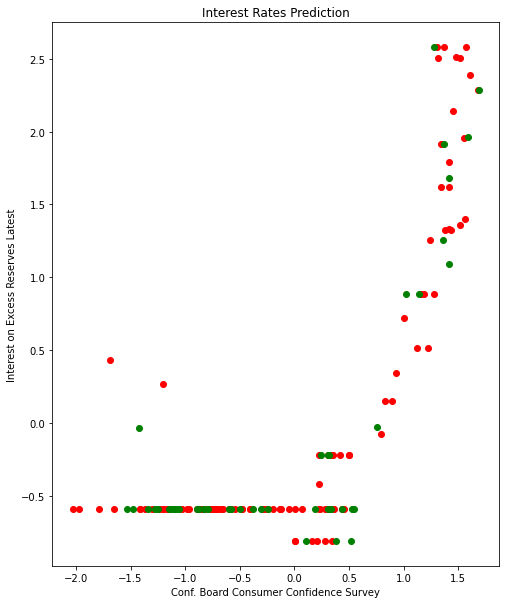

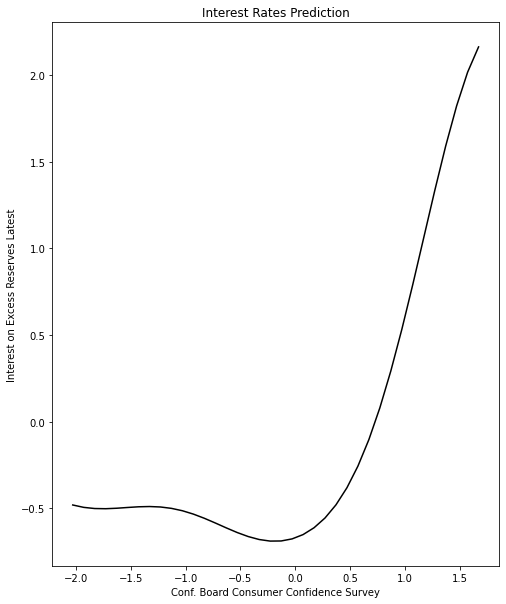

In [ ]:
# Visualising the SVR results (for higher resolution and smoother curve)
X_grid = np.arange(min(X_SVR_train['Conf. Board Consumer Confidence Survey']), max(X_SVR_train['Conf. Board Consumer Confidence Survey']), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_SVR_train['Conf. Board Consumer Confidence Survey'], y_train, color = 'red')
plt.scatter(X_SVR_test['Conf. Board Consumer Confidence Survey'], y_test, color = 'green')
plt.title('Interest Rates Prediction')
plt.xlabel('Conf. Board Consumer Confidence Survey')
plt.ylabel('Interest on Excess Reserves Latest')
plt.show()

plt.plot(X_grid, svr_rbf.predict(X_grid), color = 'black')
plt.title('Interest Rates Prediction')
plt.xlabel('Conf. Board Consumer Confidence Survey')
plt.ylabel('Interest on Excess Reserves Latest')
plt.show()

### Explain Model

In [ ]:
results_df = pd.DataFrame(columns=['Name', 'RMSE', 'R2'])
for col in X_train.columns:
    x_tr = X_train[col].to_numpy().reshape(-1,1)
    X_te = X_test[col].to_numpy().reshape(-1,1)
    svr_rbf = SVR(kernel='rbf')
    svr_lin = SVR(kernel='linear')
    svr_poly = SVR(kernel='poly')
    y_rbf = svr_rbf.fit(x_tr, y_train).predict(X_te)
    y_lin = svr_lin.fit(x_tr, y_train).predict(X_te)
    y_poly = svr_poly.fit(x_tr, y_train).predict(X_te)

    results_dic = {'rbf': y_rbf, 'linear': y_lin, 'poly': y_poly}
    max_r2 = -99
    min_rmse = -1
    for k in results_dic:
      # model evaluation
      rmse = mean_squared_error(y_test, results_dic[k])
      r2 = r2_score(y_test, results_dic[k])

      if max_r2 < r2:
        max_r2 = r2
        min_rmse = rmse
    
    results_df = results_df.append(pd.Series({'Name': col, 'RMSE': min_rmse, 'R2':max_r2}), ignore_index=True)
results_df.sort_values(by='R2', ascending=False)

,Name,RMSE,R2
13,Underemployment Rate Latest,0.064999,0.922725
20,NY New Jobs 1 Latest,0.069977,0.916807
17,Unemployment Rate Latest,0.069977,0.916807
21,NY New Jobs 1 Survey,0.072706,0.913563
18,Unemployment Rate Survey,0.072706,0.913563
2,Conf. Board Consumer Confidence Survey,0.076347,0.909234
1,Conf. Board Consumer Confidence Latest,0.096922,0.884772
31,SPY Adj-Close,0.124726,0.851717
19,US Hires Rates Latest,0.275392,0.672597
4,Long-Term Unemployment Rate Latest,0.285272,0.660850


In [ ]:
svr_rbf = SVR(kernel='rbf')
y_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)

# model evaluation
rmse = mean_squared_error(y_test, y_rbf)
r2 = r2_score(y_test, y_rbf)

# printing values
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Root mean squared error:  0.03996328312481684
R2 score:  0.9524890594079535


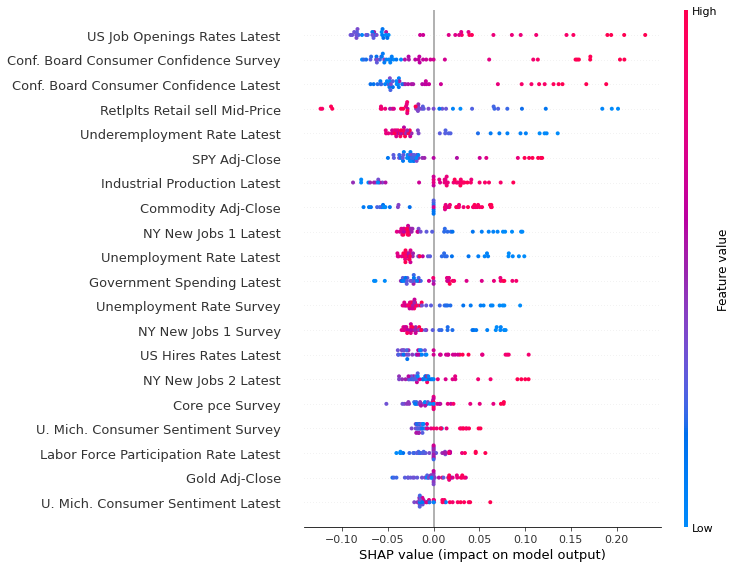

In [ ]:
explainer = shap.KernelExplainer(svr_rbf.predict, X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

## Linear Regression (LR)

### Feature Selection

In [ ]:
tscv = TimeSeriesSplit(n_splits=10)

# Sequential Forward Floating Selection(sffs)
sffs = SFS(LinearRegression(),
         k_features=(1, X_train.shape[1]),
         forward=True,
         floating=True,
         scoring='neg_root_mean_squared_error',
         n_jobs=-1,
         cv=tscv)

sffs.fit(X_train.values, y_train)
important_feat = list(sffs.k_feature_names_)
for i in important_feat:
  print(X_train.columns[int(i)])

Conf. Board Consumer Confidence Latest
Labor Force Participation Rate Latest
Long-Term Unemployment Rate Latest
U. Mich. Consumer Sentiment Latest
US Job Openings Rates Latest
Personal Consumption Latest
Retlplts Retail sell Mid-Price
Underemployment Rate Latest
Unemployment Rate Survey
US Hires Rates Latest
Nominal GDP Latest
Commodity Adj-Close
Core pce Survey


In [ ]:
X_LR_train = X_train[[X_train.columns[int(i)] for i in important_feat]]
X_LR_test = X_test[[X_train.columns[int(i)] for i in important_feat]]

### All Features

In [ ]:
lr = LinearRegression()
y_lr = lr.fit(X_LR_train, y_train).predict(X_LR_test)

# model evaluation
rmse = mean_squared_error(y_test, y_lr)
r2 = r2_score(y_test, y_lr)

# printing values
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Root mean squared error:  0.10161183972102249
R2 score:  0.8791972605114591


In [ ]:
results = pd.DataFrame([scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_lr), scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_test)]).T
results.columns = ['Prediction', 'True']
results

,Prediction,True
0,0.507270,0.250000
1,0.318207,0.250000
2,0.416094,0.250000
3,2.020882,2.200000
4,0.295528,0.100000
5,-0.040986,0.250000
6,0.319314,0.250000
7,0.473005,0.250000
8,1.619759,1.500000
9,0.268173,0.250000


### Single Feature

In [ ]:
for col in X_LR_train.columns:
    print(col)
    x_tr = X_LR_train[col].to_numpy().reshape(-1,1)
    X_te = X_LR_test[col].to_numpy().reshape(-1,1)
    lr = LinearRegression()
    y_lr = lr.fit(x_tr, y_train).predict(X_te)

    # model evaluation
    rmse = mean_squared_error(y_test, y_lr)
    r2 = r2_score(y_test, y_lr)

    # printing values
    print('\t Root mean squared error: ', rmse)
    print('\t R2 score: ', r2)

Conf. Board Consumer Confidence Latest
	 Root mean squared error:  0.38521137522496723
	 R2 score:  0.5420357555075668
Labor Force Participation Rate Latest
	 Root mean squared error:  0.8415712168789518
	 R2 score:  -0.000514396282985885
Long-Term Unemployment Rate Latest
	 Root mean squared error:  0.5159071338923678
	 R2 score:  0.3866561685430693
U. Mich. Consumer Sentiment Latest
	 Root mean squared error:  0.5366734188225231
	 R2 score:  0.36196786336672515
US Job Openings Rates Latest
	 Root mean squared error:  0.5379824275532443
	 R2 score:  0.36041162896412315
Personal Consumption Latest
	 Root mean squared error:  0.8089175113823239
	 R2 score:  0.0383064447654079
Retlplts Retail sell Mid-Price
	 Root mean squared error:  0.5784448496154836
	 R2 score:  0.31230727965915916
Underemployment Rate Latest
	 Root mean squared error:  0.391180208029125
	 R2 score:  0.5349396202907358
Unemployment Rate Survey
	 Root mean squared error:  0.4512434956472943
	 R2 score:  0.463532491880

In [ ]:
## NY New Jobs 1 Latest

x_tr = X_train['Conf. Board Consumer Confidence Survey'].to_numpy().reshape(-1,1)
X_te = X_test['Conf. Board Consumer Confidence Survey'].to_numpy().reshape(-1,1)

lr = LinearRegression()
y_lr = lr.fit(x_tr, y_train).predict(X_te)

# model evaluation
rmse = mean_squared_error(y_test, y_lr)
r2 = r2_score(y_test, y_lr)

# printing values
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Root mean squared error:  0.39452725165528313
R2 score:  0.5309604379401587


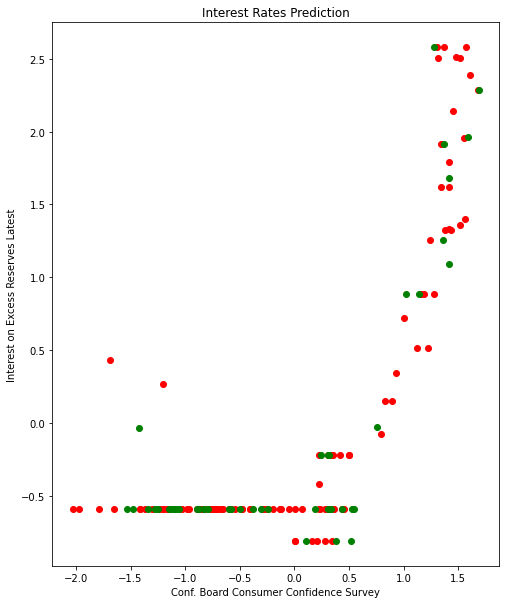

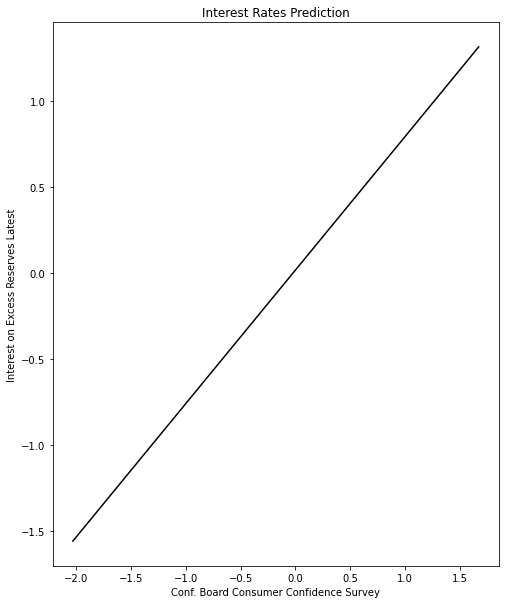

In [ ]:
# Visualising the SVR results (for higher resolution and smoother curve)
X_grid = np.arange(min(X_train['Conf. Board Consumer Confidence Survey']), max(X_train['Conf. Board Consumer Confidence Survey']), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_train['Conf. Board Consumer Confidence Survey'], y_train, color = 'red')
plt.scatter(X_test['Conf. Board Consumer Confidence Survey'], y_test, color = 'green')
plt.title('Interest Rates Prediction')
plt.xlabel('Conf. Board Consumer Confidence Survey')
plt.ylabel('Interest on Excess Reserves Latest')
plt.show()

plt.plot(X_grid, lr.predict(X_grid), color = 'black')
plt.title('Interest Rates Prediction')
plt.xlabel('Conf. Board Consumer Confidence Survey')
plt.ylabel('Interest on Excess Reserves Latest')
plt.show()

In [ ]:
# Underemployment Rate Latest

x_tr = X_train['Underemployment Rate Latest'].to_numpy().reshape(-1,1)
X_te = X_test['Underemployment Rate Latest'].to_numpy().reshape(-1,1)

lr = LinearRegression()
y_lr = lr.fit(x_tr, y_train).predict(X_te)

# model evaluation
rmse = mean_squared_error(y_test, y_lr)
r2 = r2_score(y_test, y_lr)

# printing values
print('\t Root mean squared error: ', rmse)
print('\t R2 score: ', r2)

	 Root mean squared error:  0.391180208029125
	 R2 score:  0.5349396202907358


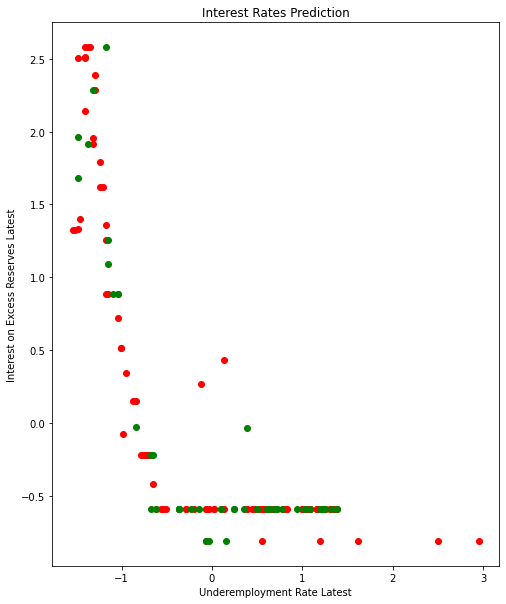

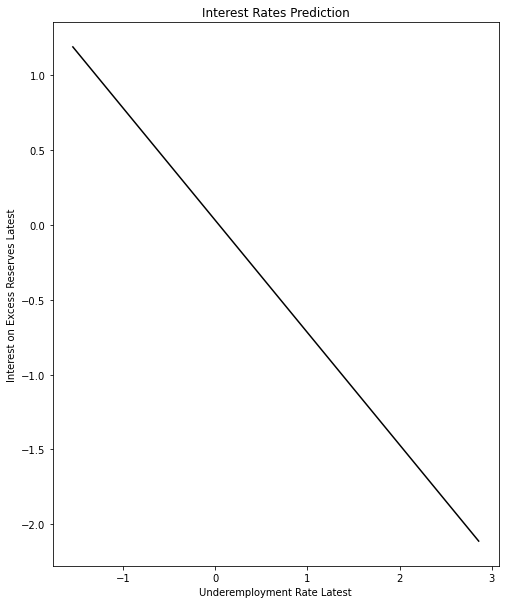

In [ ]:
# Visualising the SVR results (for higher resolution and smoother curve)
X_grid = np.arange(min(X_train['Underemployment Rate Latest']), max(X_train['Underemployment Rate Latest']), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_train['Underemployment Rate Latest'], y_train, color = 'red')
plt.scatter(X_test['Underemployment Rate Latest'], y_test, color = 'green')
plt.title('Interest Rates Prediction')
plt.xlabel('Underemployment Rate Latest')
plt.ylabel('Interest on Excess Reserves Latest')
plt.show()

plt.plot(X_grid, lr.predict(X_grid), color = 'black')
plt.title('Interest Rates Prediction')
plt.xlabel('Underemployment Rate Latest')
plt.ylabel('Interest on Excess Reserves Latest')
plt.show()

In [ ]:
lr = LinearRegression()
y_lr = lr.fit(X_train, y_train).predict(X_test)

# model evaluation
rmse = mean_squared_error(y_test, y_rbf)
r2 = r2_score(y_test, y_rbf)

# printing values
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Root mean squared error:  0.03991009379506748
R2 score:  0.9525522943298181


## Feature Selection methods

Feature selection can be done in multiple ways but there are broadly 3 categories of it:
1. Filter Method
2. Wrapper Method
3. Embedded Method

In [ ]:
X = new_df.drop('Interest on Excess Reserves Latest',1)
y = new_df['Interest on Excess Reserves Latest']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

### 1. Filter Method

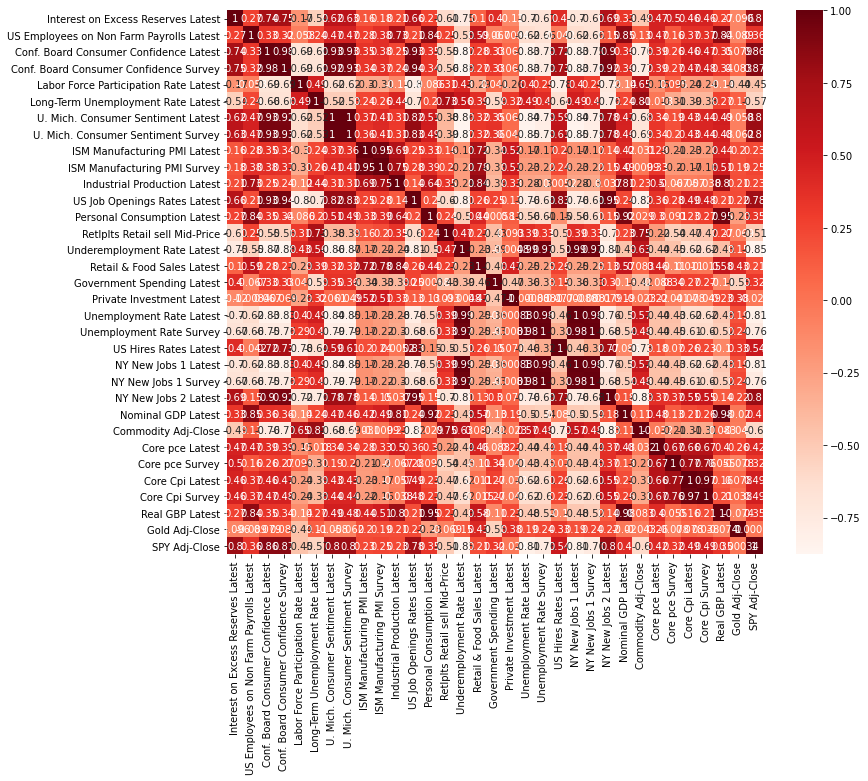

In [ ]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = new_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(cor['Interest on Excess Reserves Latest'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features.sort_values(ascending=False,inplace=True)
relevant_features

Interest on Excess Reserves Latest        1.000000
SPY Adj-Close                             0.801859
Conf. Board Consumer Confidence Survey    0.754679
Underemployment Rate Latest               0.752751
Conf. Board Consumer Confidence Latest    0.744935
NY New Jobs 1 Latest                      0.704584
Unemployment Rate Latest                  0.704584
NY New Jobs 2 Latest                      0.686828
NY New Jobs 1 Survey                      0.671179
Unemployment Rate Survey                  0.671179
US Job Openings Rates Latest              0.657458
U. Mich. Consumer Sentiment Survey        0.630136
U. Mich. Consumer Sentiment Latest        0.624984
Retlplts Retail sell Mid-Price            0.607945
Long-Term Unemployment Rate Latest        0.535659
Name: Interest on Excess Reserves Latest, dtype: float64

#### Top 3 important features:
1. SPY Adj-Close     
2. Conf. Board Consumer Confidence Survey 
3. Underemployment Rate Latest    



Lets try it in  model:

In [ ]:
important_feat = list(relevant_features.keys()[1:4])
X_SVR_train = X_train[important_feat]
X_SVR_test = X_test[important_feat]
X_SVR_train

,SPY Adj-Close,Conf. Board Consumer Confidence Survey,Underemployment Rate Latest
138,-0.467422,0.001686,2.951828
114,1.432063,1.344189,-1.207048
97,0.432334,0.500822,-0.788369
94,0.060813,0.345917,-0.732546
60,0.259407,-0.411392,0.383931
...,...,...,...
9,-1.034836,-1.306393,1.165465
103,0.601207,1.120438,-1.011665
67,-0.112114,-0.136007,0.021076
117,1.952192,1.344189,-1.318696


In [ ]:
svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')
svr_poly = SVR(kernel='poly')
y_rbf = svr_rbf.fit(X_SVR_train, y_train).predict(X_SVR_test)
y_lin = svr_lin.fit(X_SVR_train, y_train).predict(X_SVR_test)
y_poly = svr_poly.fit(X_SVR_train, y_train).predict(X_SVR_test)

results_dic = {'rbf': y_rbf, 'linear': y_lin, 'poly': y_poly}

for k in results_dic:
    print(k)
    # model evaluation
    rmse = mean_squared_error(y_test, results_dic[k])
    r2 = r2_score(y_test, results_dic[k])

    # printing values
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)

rbf
Root mean squared error:  0.04954516558812533
R2 score:  0.9410974966313828
linear
Root mean squared error:  0.30914867677607594
R2 score:  0.6324640202722271
poly
Root mean squared error:  0.2694053512771928
R2 score:  0.6797134609853508


In [ ]:
results = pd.DataFrame([scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_rbf), scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_test)]).T
results.columns = ['Prediction', 'True']
results

,Prediction,True
0,0.237357,0.250000
1,0.204872,0.250000
2,0.213395,0.250000
3,2.177020,2.200000
4,0.252967,0.100000
5,0.298049,0.250000
6,0.233336,0.250000
7,0.212030,0.250000
8,1.658598,1.500000
9,0.192068,0.250000


In Linear Regrassion Model:

In [ ]:
important_feat = list(relevant_features.keys()[1:4])
X_LR_train = X_train[important_feat]
X_LR_test = X_test[important_feat]
lr = LinearRegression()
y_lr = lr.fit(X_LR_train, y_train).predict(X_LR_test)

# model evaluation
rmse = mean_squared_error(y_test, y_lr)
r2 = r2_score(y_test, y_lr)

# printing values
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)
results = pd.DataFrame([scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_lr), scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_test)]).T
results.columns = ['Prediction', 'True']
results

Root mean squared error:  0.2853453458597556
R2 score:  0.6607629625169356


,Prediction,True
0,-0.105416,0.250000
1,0.008256,0.250000
2,0.084376,0.250000
3,1.379283,2.200000
4,0.380616,0.100000
5,0.318720,0.250000
6,0.249044,0.250000
7,-0.042666,0.250000
8,1.477562,1.500000
9,0.111543,0.250000


### 2. Wrapper Method

RFE (Recursive Feature Elimination)

In [ ]:
from sklearn.model_selection import train_test_split
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 5
Score with 5 features: 0.856873


In [ ]:
X = new_df.drop('Interest on Excess Reserves Latest',1)
y = new_df['Interest on Excess Reserves Latest']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [ ]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 3)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Conf. Board Consumer Confidence Survey',
       'Labor Force Participation Rate Latest',
       'US Job Openings Rates Latest'],
      dtype='object')


#### Top 3 important features:
1. Conf. Board Consumer Confidence Survey
2. Labor Force Participation Rate Latest
3. US Job Openings Rates Latest  



Lets try it in  model:

In [ ]:
important_feat = list(selected_features_rfe)
X_SVR_train = X_train[important_feat]
X_SVR_test = X_test[important_feat]
X_SVR_train

,Conf. Board Consumer Confidence Survey,Labor Force Participation Rate Latest,US Job Openings Rates Latest
138,0.001686,-3.025497,0.375562
114,1.344189,-0.465660,1.269614
97,0.500822,-0.655277,0.599075
94,0.345917,-0.465660,0.487319
60,-0.411392,-0.560468,-0.406733
...,...,...,...
9,-1.306393,1.999369,-1.859566
103,1.120438,-0.560468,0.487319
67,-0.136007,-0.465660,-0.071463
117,1.344189,-0.465660,1.493126


In [ ]:
svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')
svr_poly = SVR(kernel='poly')
y_rbf = svr_rbf.fit(X_SVR_train, y_train).predict(X_SVR_test)
y_lin = svr_lin.fit(X_SVR_train, y_train).predict(X_SVR_test)
y_poly = svr_poly.fit(X_SVR_train, y_train).predict(X_SVR_test)

results_dic = {'rbf': y_rbf, 'linear': y_lin, 'poly': y_poly}

for k in results_dic:
    print(k)
    # model evaluation
    rmse = mean_squared_error(y_test, results_dic[k])
    r2 = r2_score(y_test, results_dic[k])

    # printing values
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)

rbf
Root mean squared error:  0.03305507566471984
R2 score:  0.9607019840870669
linear
Root mean squared error:  0.14623521300303935
R2 score:  0.8261461027675636
poly
Root mean squared error:  0.12843897013031338
R2 score:  0.8473034294878664


In [ ]:
results = pd.DataFrame([scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_rbf), scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_test)]).T
results.columns = ['Prediction', 'True']
results

,Prediction,True
0,0.323871,0.250000
1,0.259403,0.250000
2,0.261738,0.250000
3,2.034544,2.200000
4,0.056040,0.100000
5,0.293900,0.250000
6,0.290404,0.250000
7,0.258929,0.250000
8,1.627185,1.500000
9,0.258594,0.250000


In Linear Regrassion Model:

In [ ]:
important_feat = list(selected_features_rfe)
X_LR_train = X_train[important_feat]
X_LR_test = X_test[important_feat]
lr = LinearRegression()
y_lr = lr.fit(X_LR_train, y_train).predict(X_LR_test)

# model evaluation
rmse = mean_squared_error(y_test, y_lr)
r2 = r2_score(y_test, y_lr)

# printing values
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)
results = pd.DataFrame([scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_lr), scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_test)]).T
results.columns = ['Prediction', 'True']
results

Root mean squared error:  0.15176423575369208
R2 score:  0.8195728422419486


,Prediction,True
0,0.424373,0.250000
1,0.091670,0.250000
2,-0.001180,0.250000
3,1.853462,2.200000
4,0.151706,0.100000
5,0.150991,0.250000
6,0.245259,0.250000
7,0.217594,0.250000
8,1.594859,1.500000
9,0.040769,0.250000


### 3. Embedded Method

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.327105
Best score using built-in LassoCV: 0.567085


In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 4 variables and eliminated the other 29 variables


In [ ]:
coef[coef != 0][1:3].keys()

Index(['Retlplts Retail sell Mid-Price', 'Underemployment Rate Latest'], dtype='object')

#### Top 2 important features:
1. Core pce Survey
2. SPY Adj-Close



Lets try it in  model:

Text(0.5, 1.0, 'Feature importance using Lasso Model')

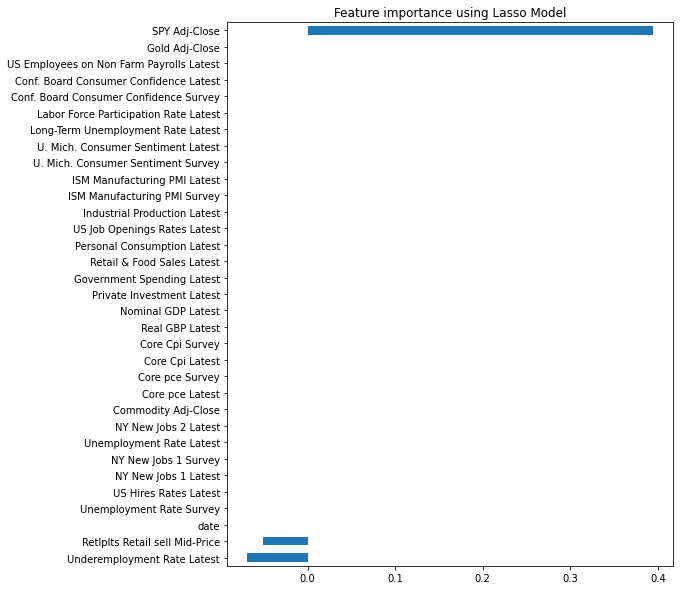

In [ ]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [ ]:
important_feat = list(coef[coef != 0][1:3].keys())
X_SVR_train = X_train[important_feat]
X_SVR_test = X_test[important_feat]
X_SVR_train

,Retlplts Retail sell Mid-Price,Underemployment Rate Latest
138,-1.783033,2.951828
114,-0.996715,-1.207048
97,-0.751670,-0.788369
94,-0.464749,-0.732546
60,1.137353,0.383931
...,...,...
9,-0.393407,1.165465
103,-0.703591,-1.011665
67,1.611936,0.021076
117,-1.365835,-1.318696


In [ ]:
svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')
svr_poly = SVR(kernel='poly')
y_rbf = svr_rbf.fit(X_SVR_train, y_train).predict(X_SVR_test)
y_lin = svr_lin.fit(X_SVR_train, y_train).predict(X_SVR_test)
y_poly = svr_poly.fit(X_SVR_train, y_train).predict(X_SVR_test)

results_dic = {'rbf': y_rbf, 'linear': y_lin, 'poly': y_poly}

for k in results_dic:
    print(k)
    # model evaluation
    rmse = mean_squared_error(y_test, results_dic[k])
    r2 = r2_score(y_test, results_dic[k])

    # printing values
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)

rbf
Root mean squared error:  0.03991009379506748
R2 score:  0.9525522943298181
linear
Root mean squared error:  0.36032189612515153
R2 score:  0.5716259810950133
poly
Root mean squared error:  0.48217320213645937
R2 score:  0.42676125256695496


In [ ]:
results = pd.DataFrame([scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_rbf), scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_test)]).T
results.columns = ['Prediction', 'True']
results

,Prediction,True
0,0.298387,0.250000
1,0.286400,0.250000
2,0.283749,0.250000
3,1.999265,2.200000
4,0.022618,0.100000
5,0.294010,0.250000
6,0.187736,0.250000
7,0.312901,0.250000
8,1.222135,1.500000
9,0.279420,0.250000


In Linear Regrassion Model:

In [ ]:
important_feat = list(coef[coef != 0][1:3].keys())
X_LR_train = X_train[important_feat]
X_LR_test = X_test[important_feat]
lr = LinearRegression()
y_lr = lr.fit(X_LR_train, y_train).predict(X_LR_test)

# model evaluation
rmse = mean_squared_error(y_test, y_lr)
r2 = r2_score(y_test, y_lr)

# printing values
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)
results = pd.DataFrame([scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_lr), scalar_dic['Interest on Excess Reserves Latest'].inverse_transform(y_test)]).T
results.columns = ['Prediction', 'True']
results

Root mean squared error:  0.37035121979962776
R2 score:  0.5597024712124996


,Prediction,True
0,0.261458,0.250000
1,-0.027130,0.250000
2,-0.114166,0.250000
3,1.508950,2.200000
4,0.902002,0.100000
5,-0.000947,0.250000
6,0.513796,0.250000
7,0.085433,0.250000
8,1.289187,1.500000
9,-0.096554,0.250000


### This 3 features has the best accuracy score:
1. Conf. Board Consumer Confidence Survey
2. Labor Force Participation Rate Latest
3. US Job Openings Rates Latest  
